<center>
    COMP4600/5300 - Reinforcement Learning

# Homework 1 - K-armed Bandit Algorithms

### Due: Monday, September 14th 11:59 pm
    
</center>

Student Name: Mohamed Martini 

The purpose of this homework is to study different properties of multi-armed bandit algorithms.

In [15]:
# You are allowed to use the following modules
import numpy as np
try:
    # If libraries already exist use interactive plots otherwise use matplotib
    import plotly.express as px
    plotly = True
except ImportError:
    plotly = False
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick

## Part 1 

Build a testbed by generating 500 randomly selected k-armed bandit problems with $k = 7$.
For each bandit problem, select the true action values from a Gaussian distribution with mean 0 and variance 1.0. For each action $a$, select an actual reward value from a normal distribution with mean $Q^*(a)$ and variance 1.0. For an algorithm, one run includes playing a single bandit problem for 1000 time steps. The algorithm's behavior will be evaluated by averaging its performance over 500 bandit problems.

In [2]:
# Write a function that generates one k-armed bandit problem
# that returns Q*(a) for that problem

# Your code here
MEAN, SIGMA = 0, 1

def k_armed_bandit(k):
    return np.random.normal(MEAN, SIGMA, k)

## Part 2

Implement the sample-average algorithm and run it on the testbed you developed in previous part according to the following settings:
1. Using greedy action selection
2. Using $\varepsilon$-greedy action selection with $\varepsilon=0.01$ and $\varepsilon=0.1$
3. Using upper-confidence bound action selection with $c=1$ and $c=2$


In [3]:
# Write a function that plays a given k-armed bandit problem
# this function should include greedy, epsilon-greedy and UCB action selection strategies.
# You can include all strategies in one function or write two functions (one for epsilon-greedy and another for UCB)
# your implementation should return the selected action and the reward gained by selecting that action

# Your code here
def get_arm(arms_values_est, eps, k):
    rand = np.random.uniform(0, 1) >= 1 - eps
    if not rand:
        return np.argmax(arms_values_est)
    # return a random arm other than the maximum
    return (np.argmax(arms_values_est) + np.random.randint(1, k)) % k

def running_ave(old_val, new_val, iteration):
    if iteration == 1:
        return new_val
    return old_val + (new_val - old_val) / iteration

def ucb(c, num_arm_iterations, iteration_total, num_arms):
    ucb_vals = np.zeros(num_arms)
    for idx, arm_iter in enumerate(num_arm_iterations):
        if arm_iter == 0:
            ucb_vals[idx] = np.inf
        else:
             ucb_vals[idx] = c * np.sqrt( np.log(iteration_total) / arm_iter )
    return ucb_vals
    
def play_k_armed_bandit(arms_values, eps, arms_values_est, k):
    """
    select the arm according to the arms_values_est list. return the arm and the reward from playing that arm.
    """
    arm = get_arm(arms_values_est, eps, k)
    reward = np.random.normal(arms_values[arm], SIGMA)
    return arm, reward


In [4]:
# Write a function that plays all the games asked in the question
# your implementation should loop over all strategies, all runs, and all time steps
# and should output the collected rewards and number of best action selections for each strategy

# Your code here
def play_all():
    # for each strategy, sum all the rewards received for each timesteps
    strategies_rewards = np.zeros((num_strategies, num_timesteps))
    strategies_best_selections = np.zeros((num_strategies, num_timesteps))

    for strat, args in strategies.items():  # 5 strategies
        for run, arms_values in enumerate(testbed):  # 500 runs
            best_arm = np.argmax(arms_values)

            num_arm_iterations = np.zeros(num_arms)  # to hold number of times each arm was played 
            arms_values_est = np.zeros(num_arms)  # estimated values for the arms
            ucb_vals = np.zeros(num_arms)

            for step in range(num_timesteps):  # 1000 timesteps
                # play arm by looking at the relavent list
                argmax_list = arms_values_est if args["c"] == 0 else arms_values_est + ucb_vals
                arm, reward = play_k_armed_bandit(arms_values, args["eps"], argmax_list, num_arms)

                # update the total reward and best_selections of this time step
                strategies_rewards[strat, step] += reward
                strategies_best_selections[strat, step] += arm == best_arm

                # update number of times the arm was played
                num_arm_iterations[arm] += 1

                # update arm's estimated value
                arms_values_est[arm] = running_ave(
                    old_val=arms_values_est[arm], 
                    new_val=reward, 
                    iteration=num_arm_iterations[arm]
                )

                # if c is non-zero, add the ucb value
                if args["c"]:
                    ucb_vals = ucb(args["c"], num_arm_iterations, step+1, num_arms)
    return strategies_rewards, strategies_best_selections

In [5]:
# Use the previous function with actual values to run the experiments
# Your code here

num_arms = 7
num_strategies = 5
num_runs = 500
num_timesteps = 1000

testbed = [k_armed_bandit(k=num_arms) for _ in range(num_runs)]    
strategies = {
    0: dict(eps=0, c=0),  # greedy
    1: dict(eps=0.1, c=0),  # eps-greedy eps = 0.1
    2: dict(eps=0.01, c=0),  # eps-greedy eps = 0.01
    3: dict(eps=0, c=1), # upper-confidence bound c = 1
    4: dict(eps=0, c=2),  # upper-confidence bound c = 2
}


In [6]:
rewards, best_selections = play_all()

49.16


For all three settings, plot the **average reward** and **%optimal action** graphs.

In [7]:
def plot(title):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,10))

    plt.suptitle(title,
                 fontweight="bold", size=16,
                 x=0.4, y=1)

    ax1.set_ylabel("Average Reward", fontsize=14)
    ax2.set_ylabel("Average % Optimal Selection", fontsize=14)
    ax2.set_xlabel("Step", fontsize=14)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax2.set_ylim([0, 100])


    for reward, sel, legend in zip(rewards_ave, best_selections_ave, legends):
        ax1.plot(reward, label=legend)
        ax2.plot(sel*100, label=legend)

    ax1.legend(prop={"size": 14}, loc='upper right', bbox_to_anchor=(1.3, 1))
    ax2.legend(prop={"size": 14}, loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.show()
    
def plot_plotly(title1, title2):
    fig1 = px.line(template="plotly_dark")
    fig1.update_layout(title_text=title1, title_x=0.5)
    fig1.update_xaxes(title_text="Step")
    fig1.update_yaxes(title_text="Average Reward")

    fig2 = px.line(template="plotly_dark")
    fig2.update_layout(title_text=title2, title_x=0.5, yaxis=dict(tickformat=".0%"))
    fig2.update_xaxes(title_text="Step")
    fig2.update_yaxes(title_text="Average % Optimal Selection")

    for reward, sel, legend in zip(rewards_ave, best_selections_ave, legends):
        fig1.add_scatter(y=reward, name=legend)
        fig2.add_scatter(y=sel, name=legend)

    fig1.show()
    fig2.show()


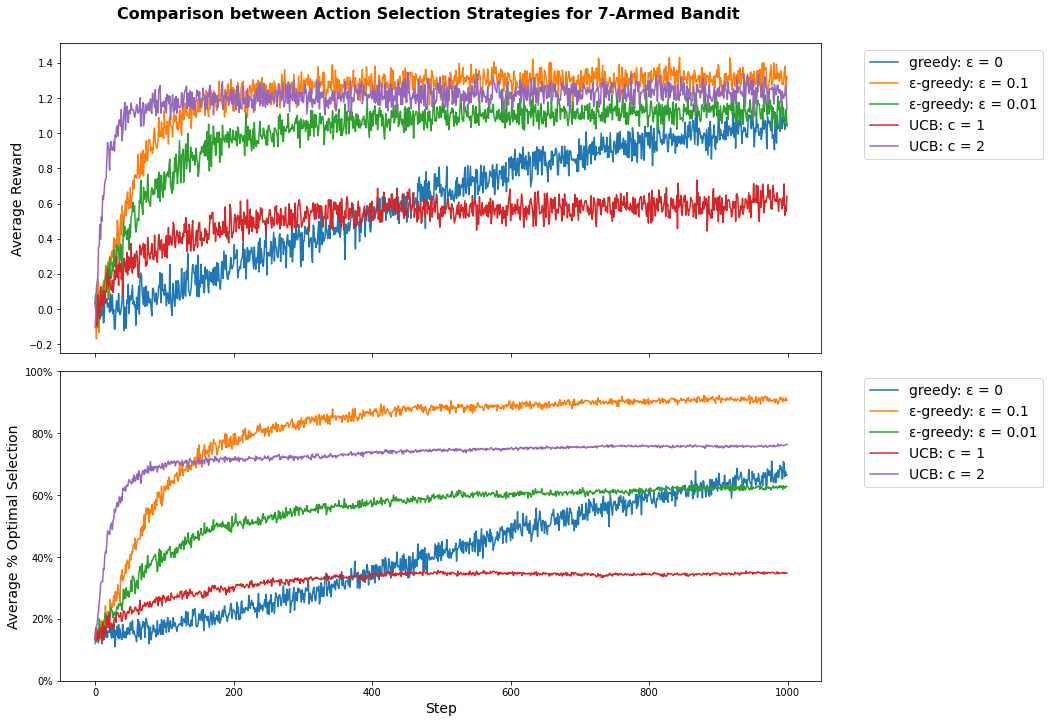

In [16]:
# Average the rewards and number of best action selections over all runs
# then plot (a) average reward, (b) %optimal action over all time steps
# you should plot two subplots (a and b) each showing all strategies

# Your code here
rewards_ave, best_selections_ave = rewards / num_runs, best_selections / num_runs
eps = "\u03B5"
legends = [
    f"greedy: {eps} = 0",
    f"{eps}-greedy: {eps} = 0.1",
    f"{eps}-greedy: {eps} = 0.01",
    "UCB: c = 1",
    "UCB: c = 2",
]
if plotly:
    plot_plotly(title1="Average Reward per Time Step for Five Action Selection Strategies", 
           title2="Average % Optimal Selection per Time Step for Five Action Selection Strategies")
else:
    plot(title=f'Comparison between Action Selection Strategies for {num_arms}-Armed Bandit')

Answer the following questions:

1. which action selection method performs worse than others? Why?
>Answer: <br> Greedy. When $\varepsilon$ = 0, the algorithm always chooses the arm with the highest expected reward, and does not explore other arms who may return higher rewards. 


2. Which $\varepsilon$ value improves faster? What is the best average reward value?
>Answer: <br> $\varepsilon$ = 0.1. <br>
Best average reward value: <br>
$\;\;\;\;\;\;$greedy: $\varepsilon$ = 0: $\;\;\;\;\;\;\;\;$ 1.08  $\;\;\;$  ```max(rewards_plot[0])```      <br>
$\;\;\;\;\;\;$$\varepsilon$-greedy: $\varepsilon$ = 0.1: $\;\;\;$ 1.30  $\;\;\;$  ```max(rewards_plot[1])```      <br>
$\;\;\;\;\;\;$$\varepsilon$-greedy: $\varepsilon$ = 0.01: $\;\;$ 1.36  $\;\;\;$  ```max(rewards_plot[2])```      <br>
$\;\;\;\;\;\;$UCB: c = 1: $\;\;\;\;\;\;\;\;\;\;\;$ 1.46  $\;\;\;$  ```max(rewards_plot[3])```      <br>
$\;\;\;\;\;\;$UCB: c = 2: $\;\;\;\;\;\;\;\;\;\;\;$ 1.43  $\;\;\;$  ```max(rewards_plot[4])```      <br>
     



3. Which $\varepsilon$ value will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be?
>Answer:<br>
$\varepsilon$ = 0.01 will perform better than $\varepsilon$ = 0 and $\varepsilon$ = 0.1 <br>
How much better will it be? <br>
In terms of % optimal action selection, it will get closer to 100% than the other $\varepsilon$ values.
In terms of average reward it will get closer to the maximum mean of a given problem.
In terms of total reward, it should be infinitely better when played an infinite amount of times.



4. What is the difference between results from $c=1$ and $c=2$? Why?
>Answer: <br>
$c=1$ performed better than $c=2$ in 500 steps, for both metrics.  
This is because in $c=2$ the algorithm explores more than in $c=1$. The $c$ term increases the weight of uncertainty, giving more edge to arms that are not played as often. The uncertainty term converges over time to 0, at which point a selection has been made for which arm to stick to. In $c=1$ this selection happens earilier than it would in $c=2$.


5. Why is there a performance spike on the 8th step for the UCB method?
>Answer: <br>
I think it is because the algorithm decided to stop exploiting and explore another arm instead. Given most arms are not as good as the expoited arm, moving to another arm would more likely yield a lower reward than that received from the exploited arm, resulting in a spike in the beginning.


## Part 3*

Implement the Gradient Bandit algorithm and plot the **average reward** and **%optimal action** graphs for the testbed you developed according to the following settings:
1. Using $\alpha=0.01$, $\alpha=0.1$, and $\alpha=0.5$
2. Using no reward baseline, reward baseline of +5, reward baseline of +10


In [9]:
# Your code here
def softmax(array):
    exp = np.exp(array - np.max(array))  # shift to avoid overflow
    return exp / np.sum(exp)

def play_gradient_bandit():
    # for each strategy, sum all the rewards received for each timesteps
    reward_per_step = np.zeros((num_strategies, num_timesteps))
    best_selection_per_step = np.zeros((num_strategies, num_timesteps))
    for strat, args in strategies.items():
        baseline = args["baseline"]
        for run, arms_values in enumerate(testbed):
            best_arm = np.argmax(arms_values)
            arms_values_est = np.zeros(num_arms) # estimated values for the arms
            Ht = np.zeros(num_arms)
            Pi = softmax(Ht)
            for step in range(num_timesteps):
                # play arm
                arm = np.random.choice(num_arms, p=Pi)
                reward = np.random.normal(arms_values[arm], SIGMA)

                # update the total reward and best_selections of this time step
                reward_per_step[strat, step] += reward
                best_selection_per_step[strat, step] += arm == best_arm

                # Ht+1
                for i in range(num_arms):
                    if i == arm:
                        Ht[arm] += args["alpha"] * (reward - baseline) * (1 - Pi[arm])
                    else:
                        Ht[i] -= args["alpha"] * (reward - baseline) * Pi[i]

                Pi = softmax(Ht)

    return reward_per_step, best_selection_per_step

In [10]:
# num_arms = 7
# num_runs = 500
# num_timesteps = 1000
# testbed = [k_armed_bandit(k=num_arms) for _ in range(num_runs)]    
strategies = {
    0: dict(alpha=0.01, baseline=0),
    1: dict(alpha=0.1, baseline=0),
    2: dict(alpha=0.1, baseline=5),
    3: dict(alpha=0.1, baseline=10),
    4: dict(alpha=0.5, baseline=0),
}
num_strategies = len(strategies)

rewards, best_selections = play_gradient_bandit()

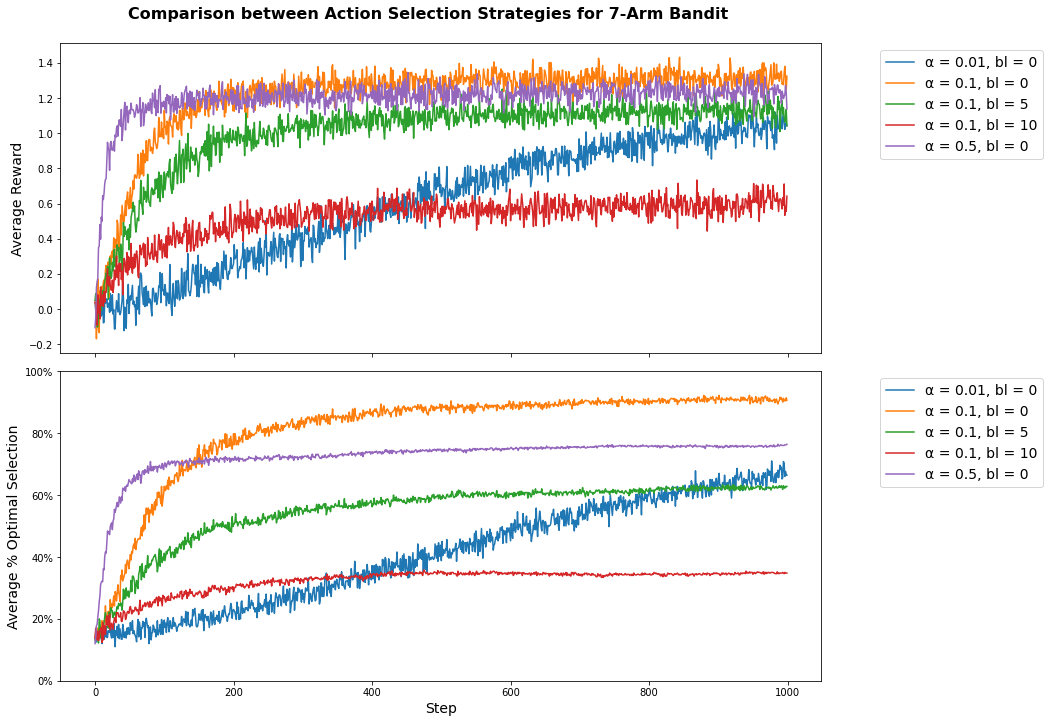

In [17]:
rewards_ave, best_selections_ave = rewards / num_runs, best_selections / num_runs
alpha = "\u03B1"
legends = [
    f"{alpha} = 0.01, bl = 0",
    f"{alpha} = 0.1, bl = 0",
    f"{alpha} = 0.1, bl = 5",
    f"{alpha} = 0.1, bl = 10",
    f"{alpha} = 0.5, bl = 0",
]

if plotly:
    plot_plotly(title1="Average Reward per Time Step for Gradient Bandit Algorithm",
                title2="Average % Optimal Selection per Time Step for Gradient Bandit Algorithm")
else:
    plot(title=f'Comparison between Action Selection Strategies for {num_arms}-Arm Bandit')

Answer the following questions:


1. How do you compare the effect of reward baseline (discuss all scenarios)?
>Answer:
When the baseline is much higher than the average reward (5 and 10), the exploitation part of the algorithm is severly affected. When an arm is picked, the more it is used, the more its probability will shrink, forcing the algorithm to pick another arm. This explains the poor performance of a baseline of 5, and the even poorer performace of baseline 10. Baseline 0 is however closer to the expected reward than 5 and 10, which explains why it performs better. If the arms were produced from a normal distribution of a mean of 5, then the baseline of 5 would perform the best.

2. How do you compare the effect of step size (discuss all scenarios)?
>Answer:
It seems that the algorithms performs better in the long run with smaller step sizes. Smaller step sizes make the algorithm less sensitive to the incoming data. As a result, the algorithm won't converge until more data is gathered and used, helping the algorithm better decide what the best arm is. If arms means were far apart, then a bigger step size could converge to the same value as a smaller step size, so it all depends on the problem at hand.
